In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import logging

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions

import pandas as pd
import numpy as np

import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

dask.config.set({"dataframe.convert-string": False})
ProgressBar().register()

from linux_qm.src.render import indigo, draw_reacting_mapnums
from linux_qm.src.util import load_smiles3D
from linux_qm.qm.orca.orca import OrcaDriver

In [3]:
df = pd.read_csv('../data/slv_amides/amide_training_set.csv', index_col='rxn_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15999 entries, 538 to 34772829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acid_smi          15999 non-null  object 
 1   amine_smi         15999 non-null  object 
 2   product_smi       15999 non-null  object 
 3   activators_names  9719 non-null   object 
 4   yield             15999 non-null  float64
dtypes: float64(1), object(4)
memory usage: 750.0+ KB


In [4]:
df['rxn_smi'] = df.amine_smi + '.' + df.acid_smi + '>>' + df.product_smi
df.rxn_smi

rxn_id
538         N[C@@H](CCCCNC(=O)C(F)(F)F)C(=O)O.OC(CCCCCCCCC...
230946      NCC(=O)NCC(=O)NCC(=O)O.OC(CSC(C)=O)=O>>[CH3:1]...
256788      NCCN.OC(=O)CCN(CCNC(=O)CCN(CCOCCOCCOCC1OCCO1)C...
371496      NCCN.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH:3]([O:19]...
371499      NCc1cccc(CN)c1.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH...
                                  ...                        
34657822    CCO[Si](CCCN)(OCC)OCC.OC(=O)CC=O>>[CH3:1][CH2:...
34683894    NCCC(=O)O.OC(C(=C)C)=O>>[CH2:1]=[C:2]([C:4]([N...
34697857    N1CCOCC1.OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]...
34705858    CC[C@H](C)N.OC(=O)c1cc(Cl)cc(F)[n]1>>[CH3:1][C...
34772829    NCc1ccccc1.OC(=O)c1[n]cc[n][n]1>>[O:1]=[C:2]([...
Name: rxn_smi, Length: 15999, dtype: object

# Filter by Heavy atom count

[21:58:17] Can't kekulize mol.  Unkekulized atoms: 16 17 18 31 32
[21:58:18] Can't kekulize mol.  Unkekulized atoms: 2 3 48 49 50
[21:58:18] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 8 28 29 30
[21:58:18] Can't kekulize mol.  Unkekulized atoms: 8 9 10 93 94
[21:58:18] WARNING: not removing hydrogen atom without neighbors
[21:58:18] WARNING: not removing hydrogen atom without neighbors
[21:58:18] WARNING: not removing hydrogen atom without neighbors
[21:58:18] WARNING: not removing hydrogen atom without neighbors
[21:58:18] Can't kekulize mol.  Unkekulized atoms: 15 17 18 19 20


<Axes: xlabel='ha_count', ylabel='Count'>

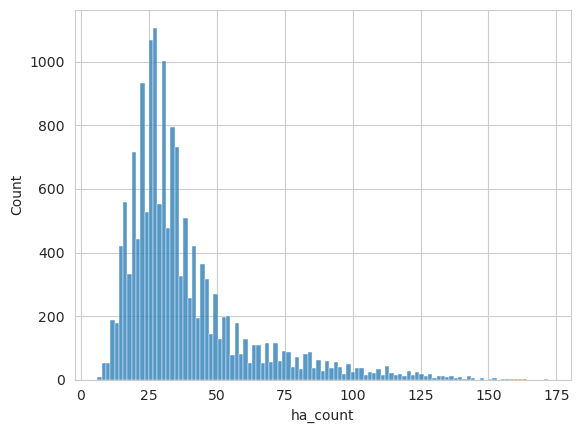

In [5]:
import seaborn as sns

def ha_count(smi: str):
    mol = Chem.MolFromSmiles(smi)
    return mol.GetNumHeavyAtoms() if mol else None


ha = df.rxn_smi.str.split('>>').apply(lambda x: x[1]).apply(ha_count)
ha.name = 'ha_count'


sns.histplot(ha)

In [6]:
df = df[ha < 40].copy()

# Reactom atom-to-atom mapping

[NH2:1][c:2]1[cH:8]cc(O)[cH:4][cH:3]1.[CH3:9][C:10](=O)[OH:11]>>CC(=O)[NH:1][c:2]1[cH:3][cH:4][c:10]([OH:11])[cH:9][cH:8]1
Reacting Atom Idx: ((0, 2, 3, 4, 5, 6), (0, 1, 2))
Mapped reacting atom: N 1
Mapped reacting atom: C 8
Mapped reacting atom: C 0
Mapped reacting atom: C 0
Mapped reacting atom: O 0
Mapped reacting atom: C 4
Mapped reacting atom: C 9
Mapped reacting atom: C 10
Mapped reacting atom: O 0


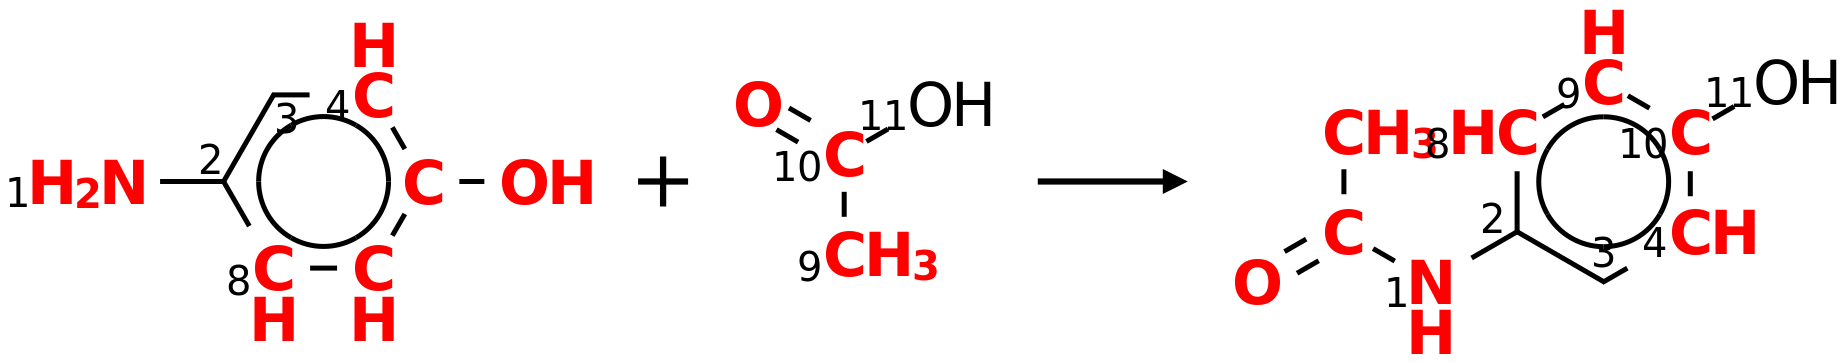

[1, 8, 0, 0, 0, 4, 9, 10, 0]

In [7]:
# rxn_smi = df.rxn_smi.sample(1).iat[0]
rxn_smi = "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc2ccc(O)cc2)=O"

ind_rxn = indigo.loadReaction(rxn_smi)
ind_rxn.automap("discard")
rxn_smi = ind_rxn.smiles()

print(rxn_smi)

draw_reacting_mapnums(rxn_smi)

In [8]:
import re

re.sub(r':\d+','',  rxn_smi)

'[NH2][c]1[cH]cc(O)[cH][cH]1.[CH3][C](=O)[OH]>>CC(=O)[NH][c]1[cH][cH][c]([OH])[cH][cH]1'

In [9]:
from rxnmapper import BatchedMapper, RXNMapper
rxn_mapper = BatchedMapper(batch_size=8)

def ind_rxn_map(rxn_smi):
    try:
        ind_rxn = indigo.loadReaction(rxn_smi)
        ind_rxn.automap("discard")
        return ind_rxn.smiles()
    except:
        return None

def rxn_map(rxn_smi):
    clear_smi = re.sub(r':\d+','',  rxn_smi)
    mapped_rxn = list(rxn_mapper.map_reactions([clear_smi]))[0]
    return mapped_rxn

In [10]:
# rxn_arr = df.rxn_smi.sample(100)
#
# %timeit list(rxn_mapper.map_reactions(rxn_arr))
# %timeit rxn_arr.apply(ind_rxn_map)
# rxn_mapper.get_attention_guided_atom_maps_for_reactions([rxn_smi])

In [11]:
df.rxn_smi = df.rxn_smi.str.replace(r':\d+','', regex=True)

In [12]:
dds = dd.from_pandas(df.rxn_smi, npartitions=128)

df.rxn_smi = dds.apply(ind_rxn_map, meta=dds). compute(scheduler='threads')

# df.rxn_smi = df.rxn_smi.apply(ind_rxn_map)

[########################################] | 100% Completed | 17.98 s


In [13]:
df.dropna(subset=['rxn_smi'], inplace=True)
df

,acid_smi,amine_smi,product_smi,activators_names,yield,rxn_smi
rxn_id,,,,,,
230946,OC(CSC(C)=O)=O,NCC(=O)NCC(=O)NCC(=O)O,[CH3:1][C:2]([S:4][CH2:5][C:6]([NH:8][CH2:9][C...,N-Hydroxysuccinimide,40.0,[NH2:1][CH2:2][C:3]([NH:5][CH2:6][C:7]([NH:9][...
371496,OC(CC(OC)OC)=O,NCCN,[CH3:1][O:2][CH:3]([O:19][CH3:20])[CH2:4][C:5]...,NaN,65.0,[NH2:1][CH2:2][CH2:3][NH2:4].[OH:5][C:6](=[O:1...
371499,OC(CC(OC)OC)=O,NCc1cccc(CN)c1,[CH3:1][O:2][CH:3]([O:25][CH3:26])[CH2:4][C:5]...,NaN,63.0,[NH2:1][CH2:2][c:3]1[cH:10][c:7]([CH2:8][NH2:9...
375178,OC(=O)[C@@H]1C[C@H]1c1cc[n]cc1,CNC,[CH3:1][N:2]([C:4]([C@H:6]1[C@H:8]([c:9]2[cH:1...,NaN,32.0,[CH3:1][NH:2][CH3:3].O[C:5]([C@H:7]1[C@H:9]([c...
380793,C(=O)CC(O)=O,NCCNCc1ccccc1,[O:1]=[C:2]([NH:17][CH2:18][CH2:19][NH:20][CH2...,NaN,69.0,[NH2:1][CH2:2][CH2:3][NH:4][CH2:5][c:6]1[cH:11...
...,...,...,...,...,...,...
34657822,OC(=O)CC=O,CCO[Si](CCCN)(OCC)OCC,[CH3:1][CH2:2][O:3][Si:4]([O:31][CH2:32][CH3:3...,NaN,89.0,[CH3:1][CH2:2][O:3][Si:4]([O:12][CH2:13][CH3:1...
34683894,OC(C(=C)C)=O,NCCC(=O)O,[CH2:1]=[C:2]([C:4]([NH:6][CH2:7][CH2:8][C:9](...,Anhydrides,57.0,[NH2:1][CH2:2][CH2:3][C:4]([OH:6])=[O:5].O[C:8...
34697857,OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]1)=O,N1CCOCC1,[CH3:1][C:2]([CH2:5][C:6]([NH:9][c:10]1[n:24][...,TBD,82.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...


[CH3:1][O:2][CH2:3][CH2:4][NH2:5].O[C:7]([CH2:9][CH2:10][N:11]([CH2:13][c:14]1[cH:19][cH:18][cH:17][cH:16][cH:15]1)[CH3:12])=[O:8]>>[CH3:1][O:2][CH2:3][CH2:4][NH:5][C:7](=[O:8])[CH2:9][CH2:10][N:11]([CH3:12])[CH2:13][c:14]1[cH:19][cH:18][cH:17][cH:16][cH:15]1
((4,), (0, 1))
Reacting Atom Idx: ((4,), (0, 1))
Mapped reacting atom: N 5
Mapped reacting atom: O 0
Mapped reacting atom: C 7


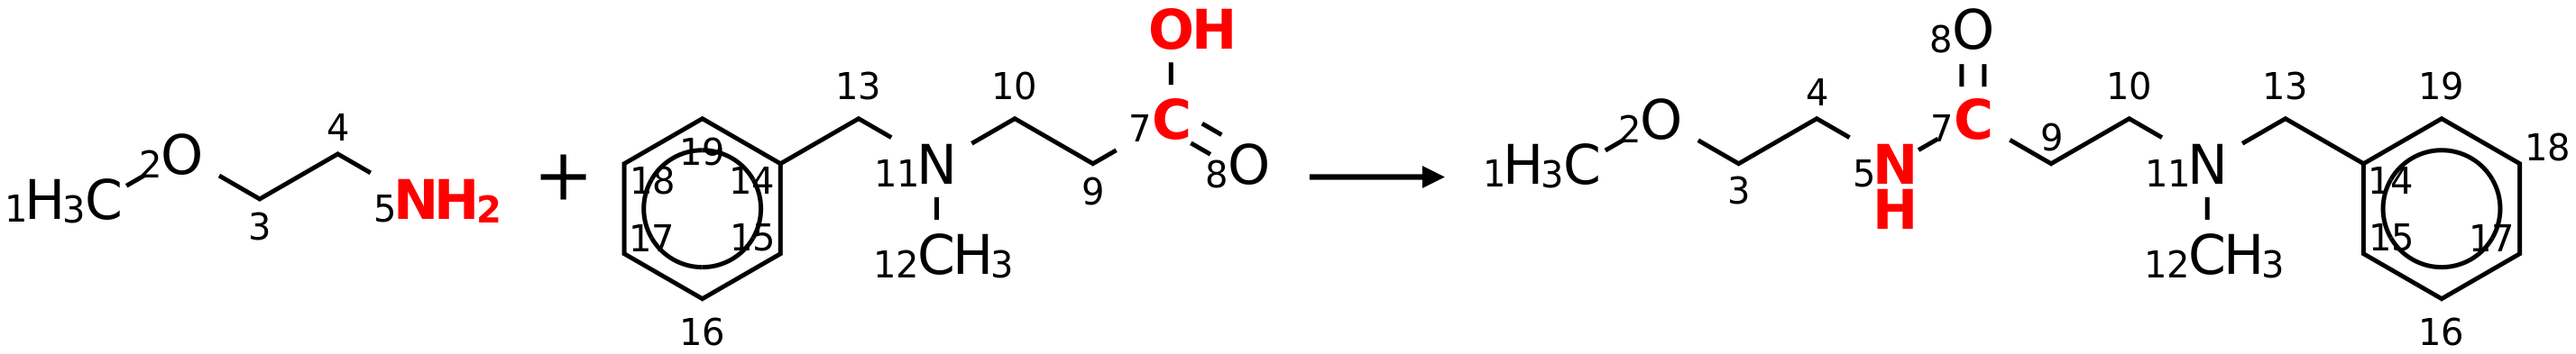

[5, 0, 7]

In [14]:
rxn_smi = df.rxn_smi.sample(1).iat[0]
print(rxn_smi)

rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
rxn.Initialize()
print(rxn.GetReactingAtoms())
draw_reacting_mapnums(rxn_smi)

# Filter by amine and acid mapping


In [15]:
def check_amide_mapping(rxn_smi):
    try:
        rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
        rxn.Initialize()
        mapped_atoms = rxn.GetReactingAtoms()
    except:
        return False

    if len(mapped_atoms) != 2:
        return False
    if len(mapped_atoms[0]) != 1:
        return False
    if len(mapped_atoms[1]) != 2:
        return False

    if len(rxn.GetProducts()) > 1:
        return False

    if len(rxn.GetReactants()) != 2:
        return False

    amine, acid = rxn.GetReactants()

    # check for amine
    if amine.GetAtomWithIdx(mapped_atoms[0][0]).GetSymbol() != 'N':
        return False

    # check acid
    symbol = acid.GetAtomWithIdx(mapped_atoms[1][0]).GetSymbol()
    if symbol not in ['C' ,'O']:
        return False
    symbol = acid.GetAtomWithIdx(mapped_atoms[1][1]).GetSymbol()
    if symbol not in ['C' ,'O']:
        return False

    return True


def map_amide_coupling(rxn_smi):
    # try indigo first
    mapped_smi = ind_rxn_map(rxn_smi)
    print(mapped_smi)
    rxn = rdChemReactions.ReactionFromSmarts(mapped_smi)
    rxn.Initialize()
    mapped_atoms = rxn.GetReactingAtoms()
    print(mapped_atoms)
    if check_amide_mapping(mapped_atoms, rxn):
        return mapped_smi

    # rxn_mapped
    mapped_smi = rxn_map(rxn_smi)
    rxn = rdChemReactions.ReactionFromSmarts(mapped_smi)
    mapped_atoms = rxn.GetReactingAtoms()
    if check_amide_mapping(mapped_atoms, rxn):
        return mapped_smi
    return None

True
Reacting Atom Idx: ((1,), (0, 1))
Mapped reacting atom: N 2
Mapped reacting atom: O 0
Mapped reacting atom: C 4


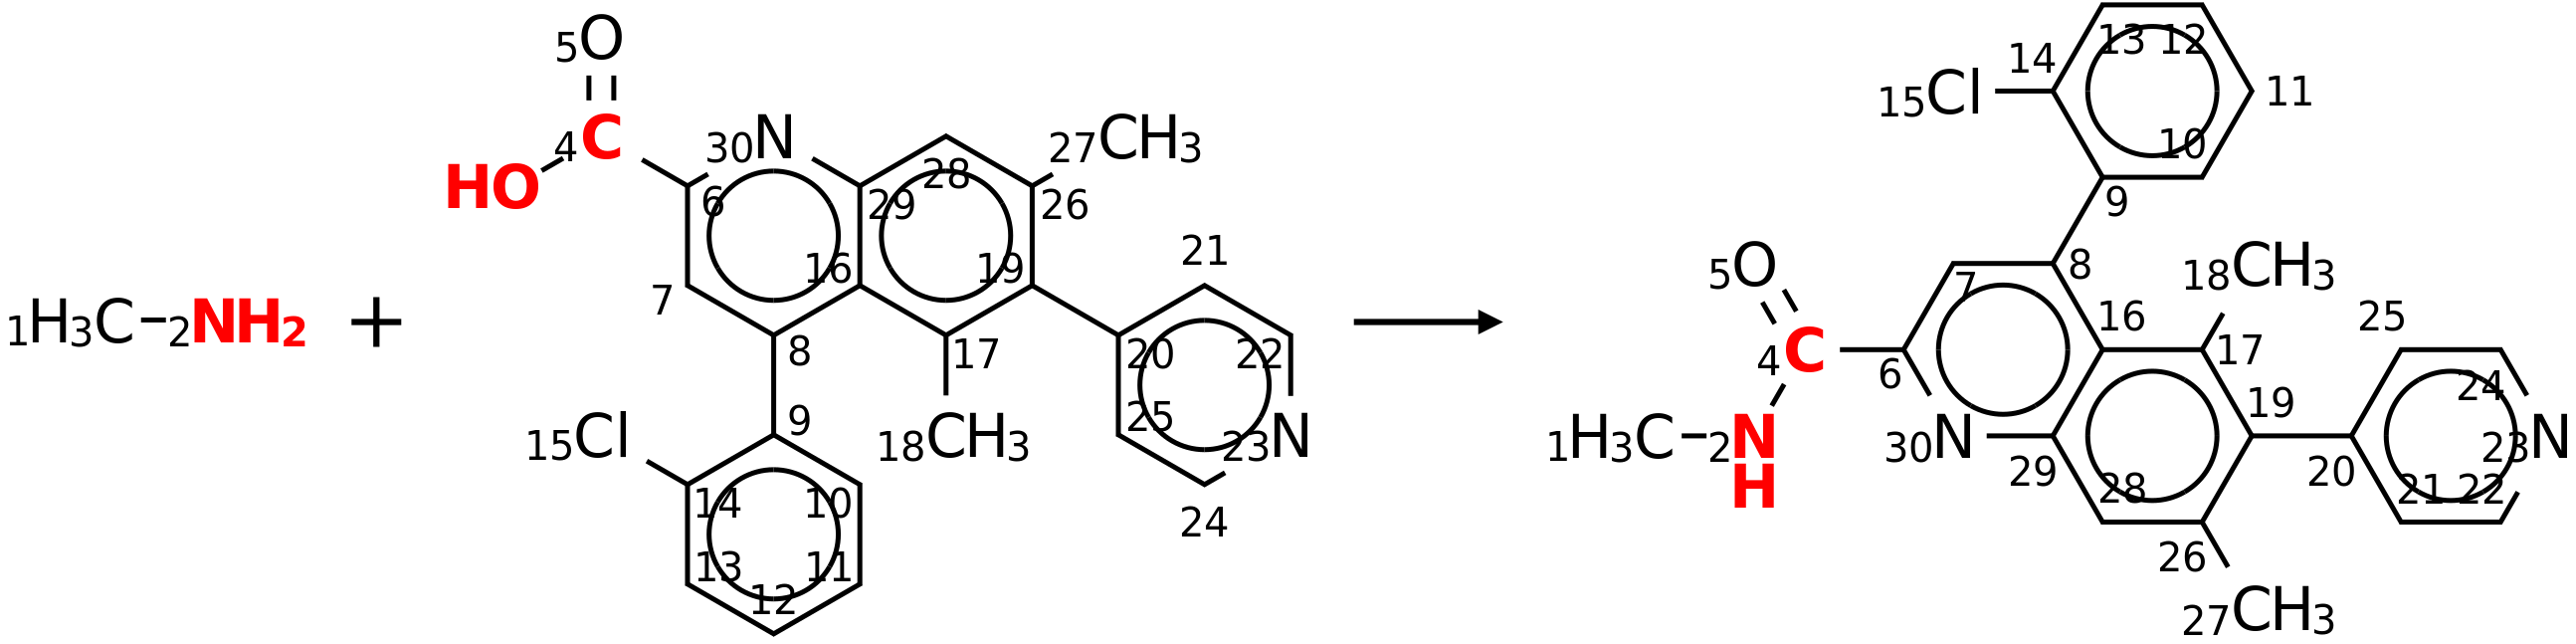

[2, 0, 4]

In [16]:
rxn_smi = df.rxn_smi.sample(1).iat[0]
print(check_amide_mapping(rxn_smi))
draw_reacting_mapnums(rxn_smi)

In [17]:
# %timeit df.rxn_smi.sample(100).apply(check_amide_mapping)

In [18]:
rxn_ok = df.rxn_smi.apply(check_amide_mapping)

Reacting Atom Idx: ((0, 1, 2, 3, 4, 5), (0, 1, 5, 7, 8, 9, 10, 11, 12, 13, 19, 20))
Mapped reacting atom: N 1
Mapped reacting atom: C 6
Mapped reacting atom: C 5
Mapped reacting atom: C 4
Mapped reacting atom: C 3
Mapped reacting atom: C 2
Mapped reacting atom: O 0
Mapped reacting atom: C 8
Mapped reacting atom: C 26
Mapped reacting atom: C 25
Mapped reacting atom: C 13
Mapped reacting atom: C 14
Mapped reacting atom: N 16
Mapped reacting atom: C 17
Mapped reacting atom: C 24
Mapped reacting atom: C 18
Mapped reacting atom: C 15
Mapped reacting atom: C 11


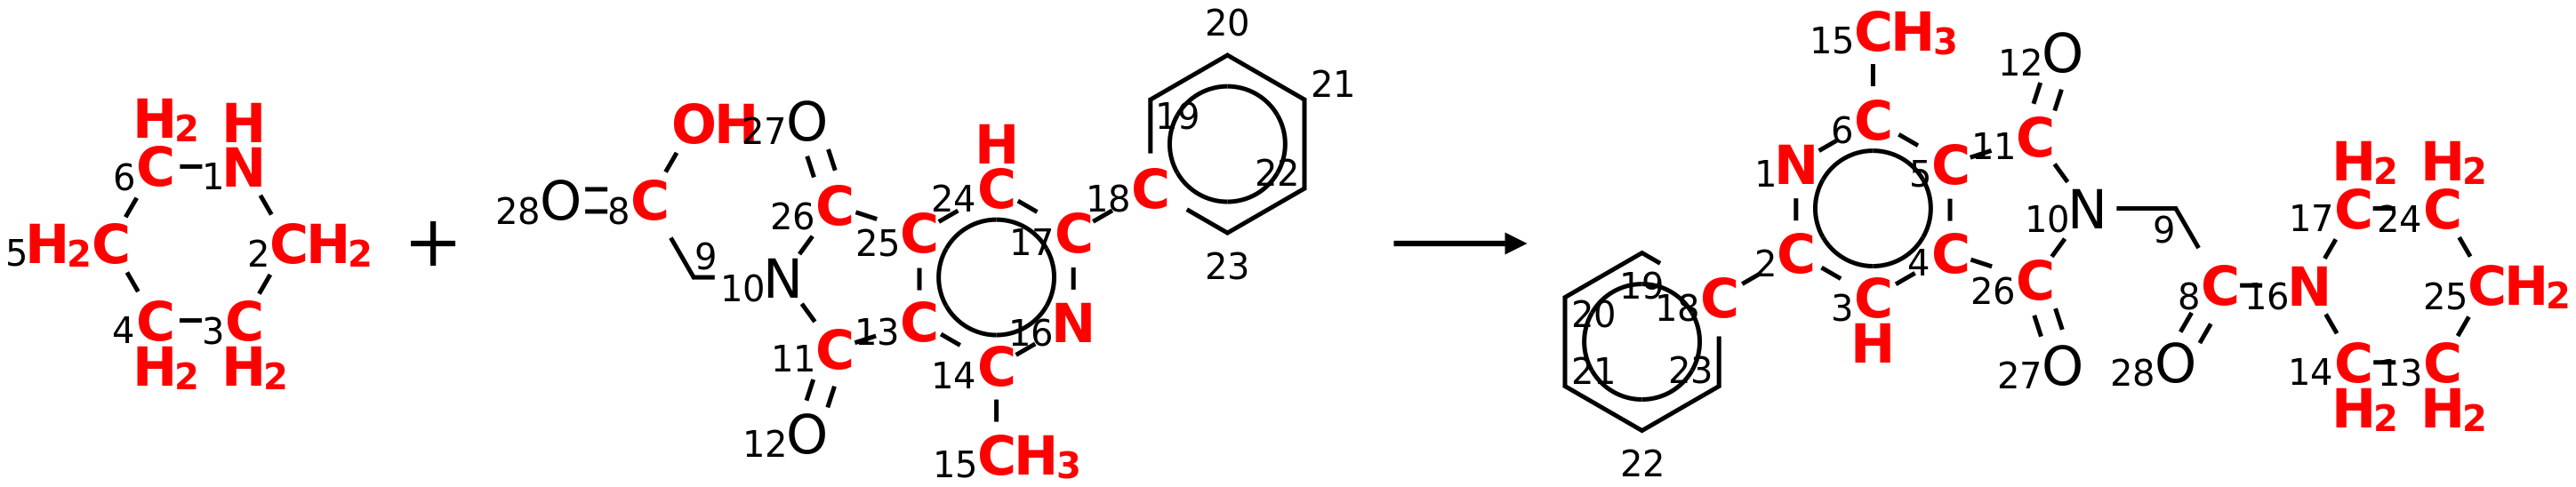

[1, 6, 5, 4, 3, 2, 0, 8, 26, 25, 13, 14, 16, 17, 24, 18, 15, 11]

In [19]:
draw_reacting_mapnums(df[~rxn_ok].rxn_smi.sample(1).iat[0])

In [20]:
df = df[rxn_ok].copy()
df.shape

(9691, 6)

In [21]:
df.to_csv('../data/slv_amides/amide_mapped_training_set.csv', index=False)

# ORCA amine calculation

In [22]:
def get_amine_atoms(mol, reacting_nitrogen_idx: int):
    amine_aids = [reacting_nitrogen_idx]
    atom = mol.GetAtomWithIdx(reacting_nitrogen_idx)
    for a in atom.GetNeighbors():
        if a.GetSymbol() == 'C':
            amine_aids.append(a.GetIdx())
    return amine_aids

def orca_calculation(conf):
    orca = OrcaDriver()

    orca.options['n_jobs'] = 1

    orca.options['method'] = 'XTB2'
    orca.geometry_optimization(conf)

    orca.options['method'] = 'HF-3c'
    # orca.options['method'] = 'BP86 def2-SVP def2/J D3BJ RIJCOSX'
    data = orca.single_point(conf, calc_npa=False)

    # data = orca.geometry_optimization(conf, calc_npa=True)
    return data

def gen_amine_electronic(rxn_smi):
    # try rxn_mapper:
    rxn_smi = rxn_map(rxn_smi)

    # load rxn
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get reactants
    amine, acid = rxn.GetReactants()
    amine_raids = get_amine_atoms(amine, rxn.GetReactingAtoms()[0][0])


    mol = load_smiles3D(Chem.MolToSmiles(amine), opt=True)

    # qm calculation
    data = orca_calculation(mol.GetConformer())

    for i in amine_raids:
        logging.debug(amine.GetAtomWithIdx(i).GetSymbol())


    mull_charges = data.atomcharges['mulliken'][amine_raids]
    low_charges = data.atomcharges['lowdin'][amine_raids]
    # npa_charges = data.atomcharges['npa'][amine_raids]

    homo = data.moenergies[0][data.homos[0]]
    lumo = data.moenergies[0][data.homos[0] + 1]

    logging.debug(f"Mulliken charges: {mull_charges}")
    logging.debug(f"Lowdig charges: {low_charges}")
    logging.debug(f"HOMO LUMO: {homo} {lumo}")

    descriptor = np.hstack([mull_charges, low_charges, homo, lumo])

    return descriptor

In [23]:
mol = load_smiles3D("NCF", opt=True)

# qm calculation
data = orca_calculation(mol.GetConformer())
data.atomcharges

{'mulliken': array([-0.513857,  0.101898, -0.342836,  0.22891 ,  0.22891 ,  0.148487,
         0.148487]),
 'lowdin': array([-0.338694,  0.130861, -0.284276,  0.158811,  0.158811,  0.087244,
         0.087244])}

In [24]:
gen_amine_electronic("Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O")

array([-0.497356  ,  0.114101  , -0.306927  ,  0.103188  , -8.11930586,
        4.78533975])

In [25]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

reactions = [
    # "Nc1ccc(C)cc1.CC(O)=O>>CC(Nc1ccc(C)cc1)=O",
    # "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(O)cc1)=O",
    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    # "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",

    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    # "Nc1ccc(NC)cc1.CC(O)=O>>CC(Nc1ccc(NC)cc1)=O",
    # "Nc1ccc(N(C)C)cc1.CC(O)=O>>CC(Nc1ccc(N(C)C)cc1)=O",

    "Nc1ccc(N(=O)=O)cc1.CC(O)=O>>CC(Nc1ccc(N(=O)=O)cc1)=O",
    "Nc1ccc(N=O)cc1.CC(O)=O>>CC(Nc1ccc(N=O)cc1)=O",
    "Nc1ccc(NO)cc1.CC(O)=O>>CC(Nc1ccc(NO)cc1)=O",
    "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",


    # "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O",
    # "Nc1ccc(Br)cc1.CC(O)=O>>CC(Nc1ccc(Br)cc1)=O",
    # "Nc1ccc(I)cc1.CC(O)=O>>CC(Nc1ccc(I)cc1)=O",
]

# labels = ['C', 'N', 'O', 'F']
# labels = ['NH2', 'NHMe', 'NMe2']
# labels = ['F', 'Cl', 'Br', 'I']
labels = ['NO2','NO', 'NH2OH', 'NH2']

amine_descr = np.empty((0, 6))
for rxn_smi in reactions:
    d = gen_amine_electronic(rxn_smi)
    amine_descr = np.vstack([amine_descr, d])

res = pd.DataFrame(amine_descr,
                   # columns=['mul_N', 'mul_C', 'low_N', 'low_C', 'npa_N', 'npa_C'],
                   columns=['mul_N', 'mul_C', 'low_N', 'low_C', 'HOMO', 'LUMO'],
                   index=labels)
res

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N           -2.81476300          0.00924764          0.26961577
C           -1.43028560         -0.05394832          0.08923084
C           -0.63469869         -0.75648119          1.00043975
C            0.76033446         -0.72842215          0.90584565
C            1.36611681          0.04725540         -0.08870858
N            2.82960091          0.08558068         -0.19375685
O            3.32597211          0.79036223         -1.08440796
O            3.48394532         -0.59163693          0.61220588
C            0.58549233          0.80111436         -0.97194531
C           -0.80815522          0.76093108         -0.86247020
H           -3.21316029         -0.79845517          0.73879075
H           -3.33454940          0.26345377         -0.56490808
H           -1.09797255         -1.33458401          1.79677662
H            1.35102173         -1.30033200          1.61807914
H

,mul_N,mul_C,low_N,low_C,HOMO,LUMO
NO2,-0.497085,0.144528,-0.295287,0.137258,-8.844353,2.542523
NO,-0.497950,0.145701,-0.295129,0.138893,-8.322602,2.746146
NH2OH,-0.498271,0.091867,-0.313463,0.076175,-7.297440,5.090189
NH2,-0.498682,0.083398,-0.315909,0.066168,-6.944536,5.388643


In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

res.iloc[:] = scaler.fit_transform(res)
res

,mul_N,mul_C,low_N,low_C,HOMO,LUMO
NO2,1.553675,0.974220,0.987985,0.970008,-1.297899,-1.073276
NO,0.080069,1.014809,1.004144,1.018606,-0.615341,-0.917102
NH2OH,-0.466784,-0.847990,-0.870981,-0.845586,0.725784,0.880735
NH2,-1.166960,-1.141040,-1.121148,-1.143028,1.187456,1.109644


<Axes: >

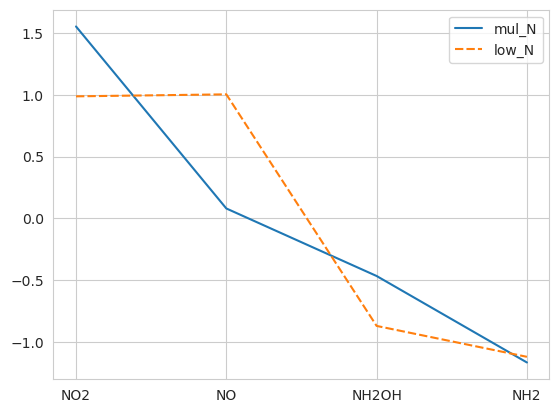

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    # res[['mul_N', 'low_N', 'npa_N']]
    res[['mul_N', 'low_N']]
)

<Axes: >

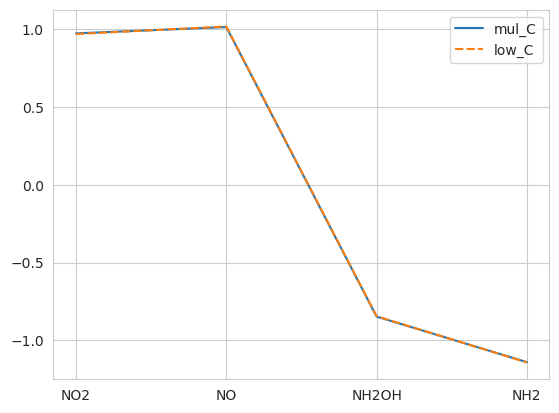

In [28]:
sns.lineplot(
    # res[['mul_C', 'low_C', 'npa_C']]
    res[['mul_C', 'low_C']]
)

<Axes: >

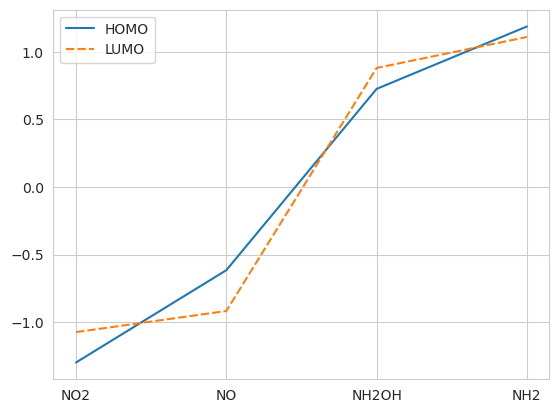

In [29]:
sns.lineplot(
    # res[['mul_C', 'low_C', 'npa_C']]
    res[['HOMO', 'LUMO']]
)

In [30]:
from linux_qm.desc import gen_amine_electronic

gen_amine_electronic("Nc1ccc(N(=O)=O)cc1.CC(O)=O>>CC(Nc1ccc(N(=O)=O)cc1)=O")

DEBUG:root:Amine atom ids: [0, 1]
INFO:root:Heavy Atom Count: 10
INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N            2.82172176          0.02532580         -0.18143110
C            1.43376333          0.02459094         -0.01746992
C            0.70053019          1.19622818         -0.23297990
C           -0.69740017          1.18545092         -0.19390914
C           -1.36944307         -0.02263583          0.02211906
N           -2.83650204         -0.04442310          0.06150547
O           -3.39261060         -1.13625090          0.24863778
O           -3.43392316          1.03078847         -0.09137937
C           -0.65167843         -1.21297724          0.18238601
C            0.74588943         -1.18319100          0.14033360
H            3.26580306          0.91765843          0.01289735
H            3.29754682         -0.74750135          0.27415485
H            1.21547289          2.13274302         -0.43486167


array([-0.497084,  0.144528, -0.295287,  0.137258, -8.844353,  2.542523])

In [31]:
import logging
logging.getLogger().setLevel(logging.WARNING)

df.rxn_smi.sample(1).apply(gen_amine_electronic)

rxn_id
22040937    [0.490954, -0.366782, 0.359485, -0.238589, -9....
Name: rxn_smi, dtype: object

# Dask parallel run

In [ ]:
dds = dd.from_pandas(df.rxn_smi.sample(512), npartitions=32)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[##                                      ] | 6% Completed | 253.10 ss

In [ ]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=24)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

In [ ]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=16)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

In [ ]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=8)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

In [ ]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=4)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

In [ ]:
%%time
df[:128].rxn_smi.apply(gen_amine_electronic)

In [ ]:
for i, row in df[:16].iterrows():
    amine_descr = gen_amine_electronic(row['rxn_smi'])
    print(amine_descr)

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)
gen_amine_electronic(df.rxn_smi.iat[2])

In [ ]:
draw_reacting_mapnums(df.rxn_smi.iat[2])